In [1]:
# import all libraries used in this notebook
import os
import numpy as np
import pandas as pd
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from IPython.core.magic import register_cell_magic
import time
from outils import load_config, log_run

In [2]:
from predictiva_previa import ajuste_previa_predictiva, plot_histogram

In [3]:
from statistics import mean

In [4]:
# Load config file calling load_config function
config_f = load_config("config.yaml")
LOGFILE = config_f["log_file"]

## Validacion de modelos: primera etapa
###  Muestreo predictivo de la distribucion previa

Para saber si nuestros modelos estan bien especificados, un paso importante es saber si la distribucion predictiva previa arroja valores que se encuentran en niveles que observariamos naturalmente. Para esto, consultamos fuentes oficiales que dan informacion sobre los niveles de radon, en particular, la EPA de Estados Unidos informa lo siguiente con respecto a niveles de radon y las consecuencias de las personas a su exposicion. 

<b> Resumir <b>

https://www.epa.gov/radon/health-risk-radon

En el reporte anterior solo se establecen rangos seguros y rangos peligrosos de exposicion al radon para los seres humanos, sin embargo, lo anterior no nos indica cuales son las concentraciones observadas de radon en la naturaleza. Con una investigacion mas detallada encontramos que los niveles de radon mas altos detectados en el mundo se han registrado en la region de Ramsar en India. En dicha region se han llegado a reportar niveles promedio anuales de radon de  372.3 pCi/L. 

<b> Poner formula de conversion. <b>

https://aerb.gov.in/images/PDF/image/34086353.pdf

Con la informacion anterior, esperariamos que nuestra distribucion predictiva previa produzca numeros entre 0 y 400, esto tomando en cuenta la escala no logaritmica de los datos. En este punto cabe senalar que, si bien, vamos a emplear una escala logaritmica para el ajuste de los modelos, las predicciones las reportaremos en su escala original de pCi/L. 

https://aerb.gov.in/images/PDF/image/34086353.pdf

Con la informacion anterior, esperariamos que nuestra distribucion predictiva previa produzca numeros entre 0 y 400, esto tomando en cuenta la escala no logaritmica de los datos. En este punto cabe senalar que, si bien, vamos a emplear una escala logaritmica para el ajuste de los modelos, las predicciones las reportaremos en su escala original de pCi/L. 

A continuacion proseguire a muestrear realizaciones de la predictiva previa para cada uno de los modelos especificados anteriormente.

## Datos

In [5]:
radon = pd.read_csv(os.path.join(config_f["data_directory"],"radon.csv"))

In [6]:
mn_radon = radon[radon['state']=='MN'].reset_index(drop=True)
mn_radon.drop(columns=['state'], inplace=True)

In [7]:
mn_radon['county_id'] = pd.factorize(mn_radon['county'])[0]+ 1

In [8]:
radon_data = {"N": len(mn_radon),
              "x": mn_radon.floor.astype(float),
              "y": mn_radon.log_radon,
              "J":85,
              "county" : mn_radon.county_id}

## Modelo 1: Regresion Lineal (no multinivel) coeficientes invariantes por condado
### Predictiva previa

Eleccion de las previas:
1) Sabemos que las medidas de radon son bajas y comprendidas entre 2 picuries por litro y 5 o 6 picuries para lugares habitacionales. 
2) Se han registrado casos extremos de presencia de radon en lugares que se conocen como High Level Radiation Areas:
    - India (Ramsar) 1800
    - Alemania
    - Dinamarca
    - China
    - Noruega
    - EUA
    - Japon
3) Esperamos una distribucion muy concentrada en niveles bajos y con colas largas
    
    
http://www.ecolo.org/documents/documents_in_english/ramsar-natural-radioactivity/ramsar.html

$ \large log\_radon_i  \sim N( \alpha + \beta Piso_i  , \sigma)$

Definicion de la predictiva previa:
- Los niveles de default del estudio producen simulaciones de la predictiva previa que no cuadran bien con los conocimientos que tenemos sobre el nivel de radon en la naturaleza.
- Ajustamos las distribuciones iniciales de manera que el intercepto de la regresion lineal, el cual de manera conceptual captura el valor promedio de las observaciones en ausencia de variables explicativas (cuando las variables explicativas son cero), represente nuestros conocimientos iniciales con respecto a la distribucion natural del radon. 
- Con respecto a las variables explicativas, no contamos con mucho conocimiento inicial sobre su distribucion, pero podemos generar ciertos supuestos, en particular, para el modelo 1 usamos como variable explicativa el piso en el cual fue generada la medicion. Podemos asumir que el nivel de radon no cambia radicalmente entre un piso y otro, ya que el nivel de radon en una zona depende de la cantidad de uranio en descomposicion. Asumimos que la disminucion de radon es baja entre basement y primer piso y por lo tanto, otorgamos una distribucion inicial a beta que tendra una media y una varianza pequena. 

$ \large log\_radon_i  \sim N( \alpha + \beta Piso_i  , \sigma)$

$\large \alpha \sim N(1,1)$ <br>
$\large \beta \sim N(0,1)$ <br>
$\large \sigma \sim N(0,1)$

Previas

In [9]:
previa_model_string = """
data {
  int<lower=0> N;
  vector[N] x;
}
generated quantities {
  real alpha = normal_rng(1, 1);
  real beta = normal_rng(0, 1);
  real sigma = fabs(normal_rng(0, 1));
  real y_sim[N] = normal_rng(alpha + beta * x, sigma);
}
"""

In [10]:
summary, y_sim_df, y_sim_original, column_means, column_max, column_min, pct_95, pct_99 = ajuste_previa_predictiva("pooling_previa.stan",previa_model_string, radon_data)

01:33:35 - cmdstanpy - INFO - compiling stan file /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/pooling_previa.stan to exe file /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/pooling_previa
01:33:47 - cmdstanpy - INFO - compiled model executable: /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/pooling_previa
01:33:47 - cmdstanpy - WARNING - Stan compiler has produced 2 warnings:
01:33:47 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/pooling_previa.hpp /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/pooling_previa.stan
Warning in '/home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-pro

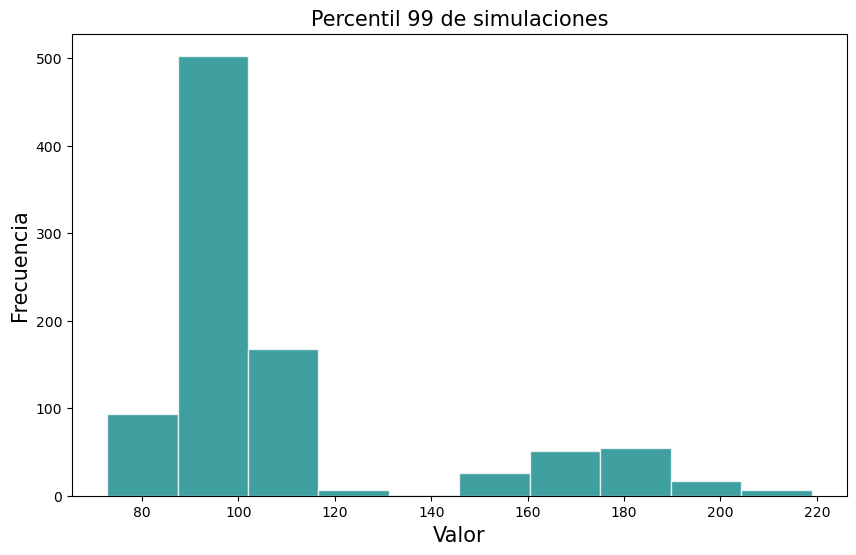

In [25]:
plot_histogram(pct_99, "Percentil 99 de simulaciones")
plt.savefig(os.path.join(config_f["results_directory"], "Percentil99_simulaciones_modelo1"))

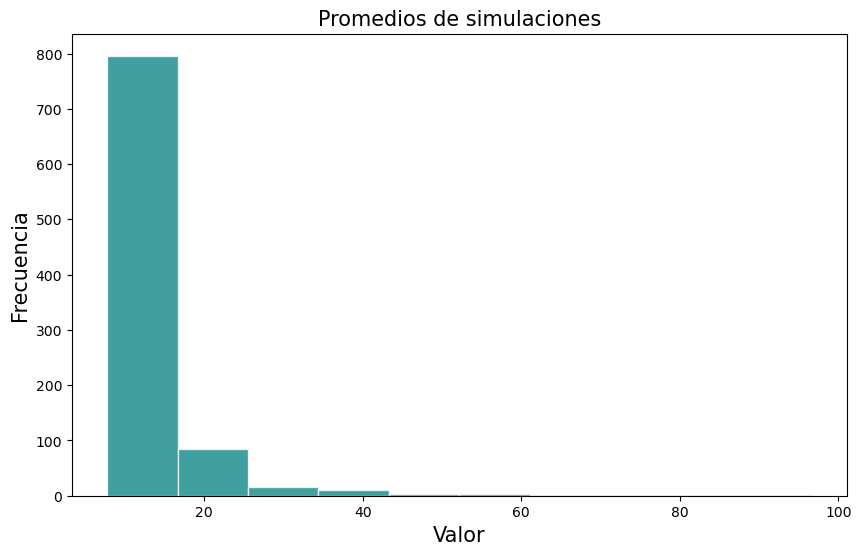

In [26]:
plot_histogram(column_means, "Promedios de simulaciones",data_lim=True)
plt.savefig(os.path.join(config_f["results_directory"], "promedio_simulaciones_modelo1"))

## Modelo 2: Regresion Lineal (no multinivel) intercepto variantes por condado
### Predictiva previa

$ \large log\_radon_i  \sim N( \alpha_{j[i]} + \beta Piso_i  , \sigma)$

$\large \alpha_j \sim N(1,1)$ <br>
$\large \beta \sim N(0,1)$ <br>
$\large \sigma \sim N(0,1)$

In [40]:
modelstring="""
data {
  int<lower=0> N;  // observations
  int<lower=1> J;  // counties
  array[N] int<lower=1, upper=J> county;
  vector[N] x;     // floor
}
generated quantities {
  vector[J] alpha;
  real beta = normal_rng(0, 1);
  real sigma = fabs(normal_rng(0, 1));
  
  for (j in 1:J) {
    alpha[j] = normal_rng(1, 1);
  }

  real y_sim[N] = normal_rng(alpha[county] + beta * x, sigma);
}
"""

In [41]:
summary, y_sim_df, y_sim_original, column_means, column_max, column_min, pct_95, pct_99 = ajuste_previa_predictiva("partial_pooling_previa.stan",modelstring, radon_data)

07:45:53 - cmdstanpy - INFO - compiling stan file /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/partial_pooling_previa.stan to exe file /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/partial_pooling_previa
07:46:04 - cmdstanpy - INFO - compiled model executable: /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/partial_pooling_previa
07:46:04 - cmdstanpy - WARNING - Stan compiler has produced 2 warnings:
07:46:04 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/partial_pooling_previa.hpp /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/partial_pooling_previa.stan
Warning in '/home/juanpalms/Desktop/MCD/Bay

In [42]:
y_sim_df.describe()

,y_sim[1],y_sim[2],y_sim[3],y_sim[4],y_sim[5],y_sim[6],y_sim[7],y_sim[8],y_sim[9],y_sim[10],...,y_sim[918],y_sim[919],y_sim[920],y_sim[921],y_sim[922],y_sim[923],y_sim[924],y_sim[925],y_sim[926],y_sim[927]
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,18.624318,9.273624,46.862091,9.511418,16.903101,8.806707,11.318278,9.342860,9.589933,11.504817,...,14.191714,9.616468,17.438608,9.271732,9.875083,9.044045,10.762066,9.963596,11.073772,10.976162
std,294.215369,101.236401,2626.850395,82.206965,601.871454,64.272187,130.690539,59.893803,57.752124,191.448248,...,258.698562,86.394310,154.185322,67.911954,95.104135,63.586858,116.403512,131.961634,246.849891,154.561203
min,0.000196,0.000183,0.001534,0.000450,0.000411,0.000713,0.001342,0.000396,0.000788,0.001951,...,0.000360,0.000782,0.000107,0.002831,0.000831,0.000120,0.000729,0.000108,0.000831,0.000061
25%,0.884956,1.126109,1.139785,1.108313,1.166769,1.133421,1.178398,1.152997,1.141752,1.161984,...,1.160467,1.125514,0.902603,1.131775,1.183069,1.140134,1.152205,1.139593,1.174661,1.149243
50%,2.723520,2.723315,2.689254,2.673578,2.735188,2.703620,2.703694,2.767931,2.715834,2.738253,...,2.728754,2.739143,2.722267,2.694849,2.816148,2.692543,2.737144,2.732577,2.704505,2.696496
75%,8.076935,6.288248,6.381911,6.348256,6.495665,6.381735,6.454322,6.532551,6.476563,6.492937,...,6.553030,6.382964,8.391632,6.435149,6.503708,6.435102,6.492207,6.452096,6.344178,6.307677
max,21585.131496,9394.972643,225460.442218,6022.393195,58588.868489,4615.520846,10013.705664,3424.394682,2888.810198,17780.719943,...,19760.296969,7419.374252,10391.568135,3944.431041,8406.327710,3784.919888,7628.679176,12397.746485,23949.434719,11000.543944


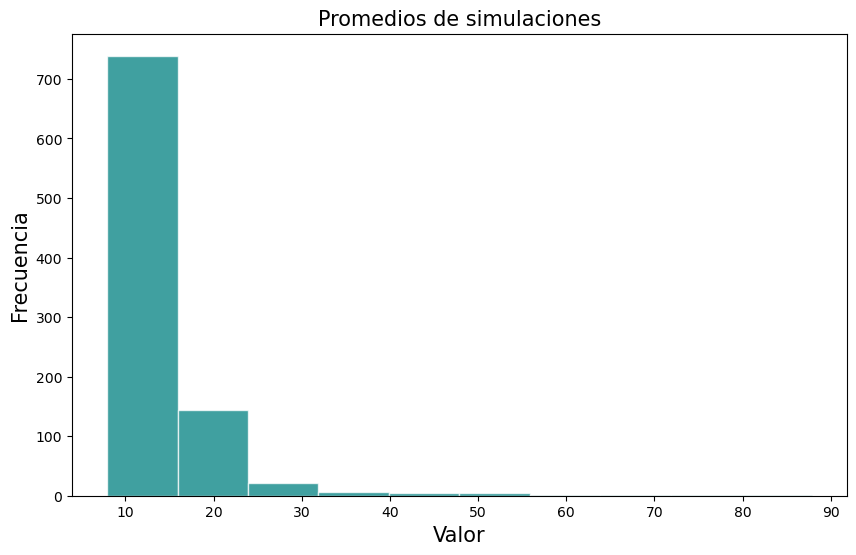

In [43]:
plot_histogram(column_means, "Promedios de simulaciones",data_lim=True)
plt.savefig(os.path.join(config_f["results_directory"], "Promedios_simulaciones_modelo2"))

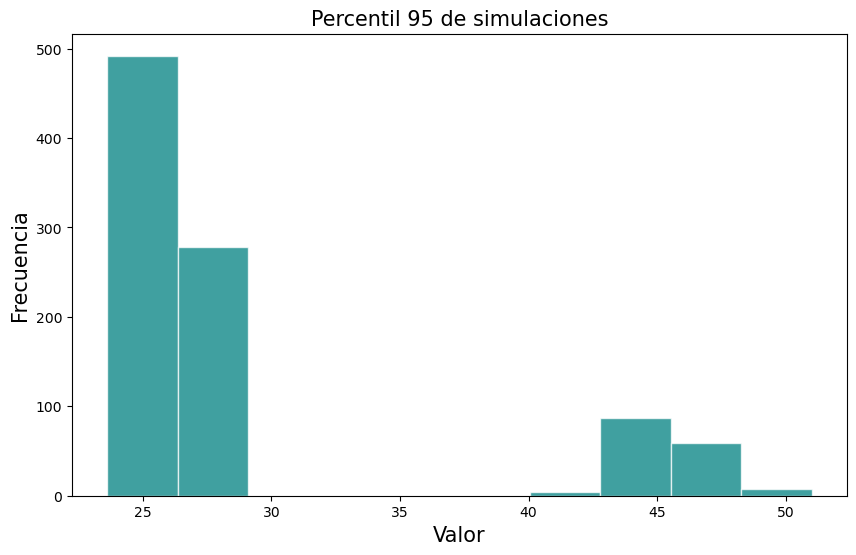

In [44]:
plot_histogram(pct_95, "Percentil 95 de simulaciones")
plt.savefig(os.path.join(config_f["results_directory"], "Percentil99_simulaciones_modelo2"))

## Modelo 3: modelo jerarquico intercepto variantes por condado (partial pooling)

### Modelo parcialmente agrupado

$ \large log\_radon_i  \sim N( \alpha_{j[i]} + \beta Piso_i  , \sigma)$ <br>

$\large \alpha_j \sim N(\mu_\alpha,\sigma_\alpha)$ <br>
$\large \mu_\alpha \sim N(1,1)$ <br>
$\large \sigma_\alpha \sim N(0,1)$ <br>
$\large \beta \sim N(0,1)$ <br>
$\large \sigma \sim N(0,1)$

$\large j \in \{1,2....85\}$

In [47]:
modelString="""
data {
  int<lower=0> N;  // observations
  int<lower=1> J;  // counties
  array[N] int<lower=1, upper=J> county;
  vector[N] x;     // floor
}
generated quantities {
  real mu_alpha = normal_rng(1, 1);
  real<lower=0> sigma_alpha = fabs(normal_rng(0, 1));
  vector[J] alpha;
  
  for (j in 1:J) {
    alpha[j] = normal_rng(mu_alpha, sigma_alpha);
  }

  real beta = normal_rng(0, 1);
  real sigma = fabs(normal_rng(0, 1));

  real y_sim[N] = normal_rng(alpha[county] + beta * x, sigma);
}
"""

In [48]:
summary, y_sim_df, y_sim_original, column_means, column_max, column_min, pct_95, pct_99 = ajuste_previa_predictiva("model_parcialmente_agrupado_previa.stan",modelString, radon_data)

07:57:07 - cmdstanpy - INFO - compiling stan file /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/model_parcialmente_agrupado_previa.stan to exe file /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/model_parcialmente_agrupado_previa
07:57:19 - cmdstanpy - INFO - compiled model executable: /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/model_parcialmente_agrupado_previa
07:57:19 - cmdstanpy - WARNING - Stan compiler has produced 3 warnings:
07:57:19 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/model_parcialmente_agrupado_previa.hpp /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/model_parcialmente_agru

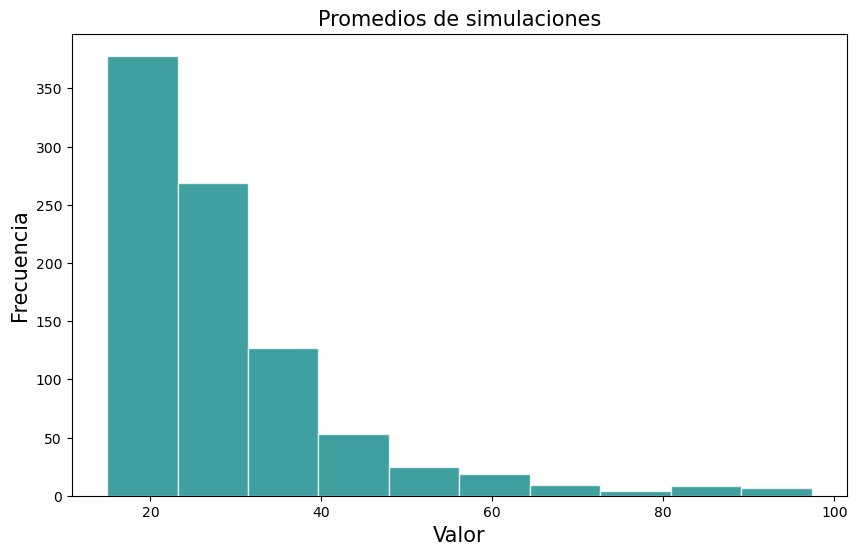

In [49]:
plot_histogram(column_means, "Promedios de simulaciones",data_lim=True)
plt.savefig(os.path.join(config_f["results_directory"], "Promedio_simulaciones_modelo3"))

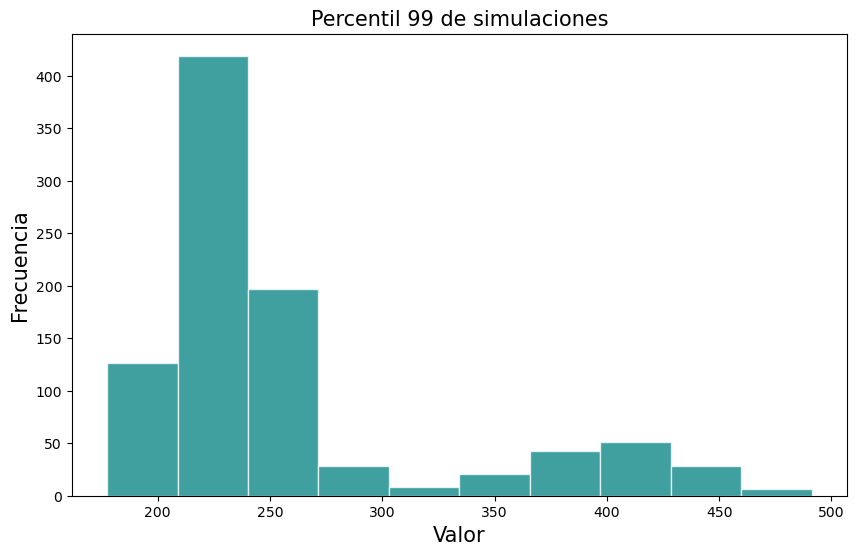

In [50]:
plot_histogram(pct_99, "Percentil 99 de simulaciones")
plt.savefig(os.path.join(config_f["results_directory"], "Percentil99_simulaciones_modelo3"))

## 4 Modelo parcialmente agrupado: distintos interceptos y coeficientes por condado

Modelo parcialmente agrupado B

$ \large log\_radon_i  \sim N( \alpha_{j[i]} + \beta Piso_i  , \sigma)$ <br>

$\large \alpha_j \sim N(\mu_\alpha,\sigma_\alpha)$ <br>
$\large \mu_\alpha \sim N(1,1)$ <br>
$\large \sigma_\alpha \sim N(0,1)$ <br>
$\large \beta_j \sim N(\mu_\beta,\sigma_\beta)$ <br>
$\large \mu_\beta \sim N(0,1)$ <br>
$\large \sigma_\beta \sim N(0,1)$ <br>
$\large \sigma \sim N(0,1)$

In [51]:
modelString="""
data {
  int<lower=0> N;  // observations
  int<lower=1> J;  // counties
  array[N] int<lower=1, upper=J> county;
  vector[N] x;     // floor
}
generated quantities {
  real mu_alpha = normal_rng(1, 1);
  real<lower=0> sigma_alpha = fabs(normal_rng(0, 1));
  vector[J] alpha;
  
  for (j in 1:J) {
    alpha[j] = normal_rng(mu_alpha, sigma_alpha);
  }
  
  real mu_beta = normal_rng(0, 1);
  real<lower=0> sigma_beta = fabs(normal_rng(0, 1));
  vector[J] beta;
  
  for (j in 1:J) {
    beta[j] = normal_rng(mu_beta, sigma_beta);
  }
  
  real sigma = fabs(normal_rng(0, 1));

  real y_sim[N];
  
  for (i in 1:N) {
    y_sim[i] = normal_rng(alpha[county[i]] + beta[county[i]] * x[i], sigma);
  }
}
"""

In [52]:
summary, y_sim_df, y_sim_original, column_means, column_max, column_min, pct_95, pct_99 = ajuste_previa_predictiva("model_parcialmente_agrupadoB_previa.stan",modelString, radon_data)

08:06:12 - cmdstanpy - INFO - compiling stan file /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/model_parcialmente_agrupadoB_previa.stan to exe file /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/model_parcialmente_agrupadoB_previa
08:06:24 - cmdstanpy - INFO - compiled model executable: /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/model_parcialmente_agrupadoB_previa
08:06:24 - cmdstanpy - WARNING - Stan compiler has produced 4 warnings:
08:06:24 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/model_parcialmente_agrupadoB_previa.hpp /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/model_parcialmente_

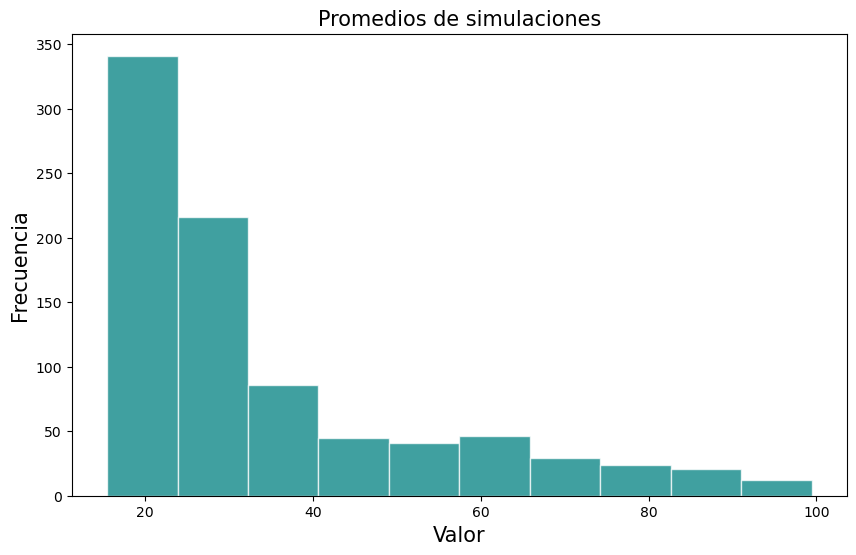

In [53]:
plot_histogram(column_means, "Promedios de simulaciones",data_lim=True)
plt.savefig(os.path.join(config_f["results_directory"], "Promedio_simulaciones_modelo4"))

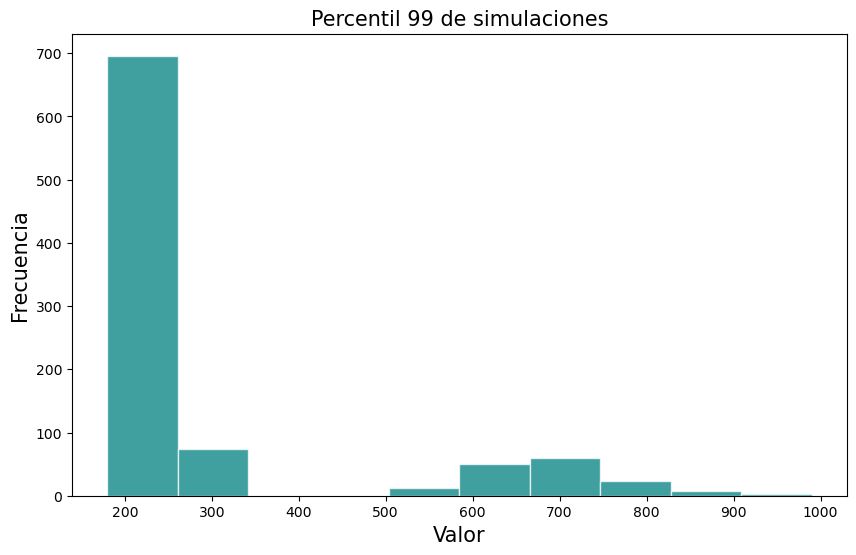

In [54]:
plot_histogram(pct_99, "Percentil 99 de simulaciones")
plt.savefig(os.path.join(config_f["results_directory"], "Percentil99_simulaciones_modelo4"))